#### Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd "/content/drive/MyDrive/IASNLP"

/content/drive/MyDrive/IASNLP


# Importing Necessary Libraries

In [ ]:
!pip install sentencepiece
!pip install sacrebleu
!pip install tensorflow-gpu # ---> For GPU

In [4]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Lambda, Layer, Embedding, LayerNormalization
import sentencepiece as spm
from sacrebleu.metrics import BLEU, CHRF, TER

import matplotlib.pyplot as plt

from collections import Counter

# Loading Data

We load the `train_data`, `train_dev_data`, `test_val_data` and `test_data` as well as the byte-pair encoder tokenizer for English and Bengali i.e. `sp_en_bpe` and `s_ben_bpe`.

In [5]:
train_data, train_dev_data = pd.read_csv("train_data.csv")[['src', 'tgt']], pd.read_csv("train_dev.csv")[['src', 'tgt']] 
test_val_data, test_data = pd.read_csv("test_val.csv")[['src', 'tgt']], pd.read_csv("test_data.csv")[['src', 'tgt']]
sp_en_bpe, sp_ben_bpe = spm.SentencePieceProcessor(), spm.SentencePieceProcessor()
sp_en_bpe.load('eng_bpe.model'); sp_ben_bpe.load('ben_bpe.model');

# Data Preprocessing

We decide on some formats of the data and batches. We take the maximum tokens we can have per tokenized English and Bengali sentence to be `MAX_TOKENS = 60`. We use the vocabulary size of `32000`(i.e. `ENCODER_VOCAB = DECODER_VOCAB = 32000`). A batch size of `256` was choosen for our Mini-Batch Gradient Descent which is used to train our Model.

In [6]:
MAX_TOKENS = 60
VOCAB_SIZE = 32000
BATCH_SIZE = 256
BUFFER_SIZE = BATCH_SIZE*4

The following two functions help in tokenizing an detokenizing the data based on our sentencepiece byte-pair encoding model.

In [7]:
def tokenize(sentence, sp_model, add_bos = True, add_eos = True):
    bos = [sp_model.bos_id()] if add_bos else []
    eos = [sp_model.eos_id()] if add_eos else []
    inputs = bos + sp_model.encode_as_ids(sentence) + eos
    return np.reshape(np.array(inputs), [1, -1])
def detokenize(tokenized, sp_model, is_bos = True, is_eos = True):
    integers = np.squeeze(tokenized).tolist()
    if is_eos:
        return sp_model.DecodeIdsWithCheck(integers[int(is_bos):integers.index(sp_model.eos_id())])
    else:
        if sp_model.pad_id() in tokenized:
            return sp_model.DecodeIdsWithCheck(integers[int(is_bos):integers.index(sp_model.pad_id())])
        else:
            return sp_model.DecodeIdsWithCheck(integers[int(is_bos):])

We have tokenized the data.

In [8]:
# Tokenization
src_train_data_enc = [np.squeeze(tokenize(train_data['src'].iloc[i], sp_en_bpe)) for i in range(train_data.shape[0])]
tgt_train_data_enc = [np.squeeze(tokenize(train_data['tgt'].iloc[i], sp_ben_bpe)) for i in range(train_data.shape[0])]
src_train_dev_data_enc = [np.squeeze(tokenize(train_dev_data['src'].iloc[i], sp_en_bpe)) for i in range(train_dev_data.shape[0])]
tgt_train_dev_data_enc = [np.squeeze(tokenize(train_dev_data['tgt'].iloc[i], sp_ben_bpe)) for i in range(train_dev_data.shape[0])]
src_test_val_data_enc = [np.squeeze(tokenize(test_val_data['src'].iloc[i], sp_en_bpe)) for i in range(test_val_data.shape[0])]
tgt_test_val_data_enc = [np.squeeze(tokenize(test_val_data['tgt'].iloc[i], sp_ben_bpe)) for i in range(test_val_data.shape[0])]

We have padded the data with post-truncation and post padding upto MAX_TOKENS number of tokens.

In [9]:
# Padding
# The reason why we add MAX_TOKENS+1 after-pad length for Bengali is that when we form the tf.Dataset later, we will shift the target sentence once and will truncate the last token once
# Hence, it will get adjusted
train_src = tf.keras.preprocessing.sequence.pad_sequences(src_train_data_enc, maxlen = MAX_TOKENS, padding='post', truncating='post')
train_tgt = tf.keras.preprocessing.sequence.pad_sequences(tgt_train_data_enc, maxlen = MAX_TOKENS, padding='post', truncating='post')
train_dev_src = tf.keras.preprocessing.sequence.pad_sequences(src_train_dev_data_enc, maxlen = MAX_TOKENS, padding='post', truncating='post')
train_dev_tgt = tf.keras.preprocessing.sequence.pad_sequences(tgt_train_dev_data_enc, maxlen = MAX_TOKENS, padding='post', truncating='post')
test_val_src = tf.keras.preprocessing.sequence.pad_sequences(src_test_val_data_enc, maxlen = MAX_TOKENS, padding='post', truncating='post')
test_val_tgt = tf.keras.preprocessing.sequence.pad_sequences(tgt_test_val_data_enc, maxlen = MAX_TOKENS, padding='post', truncating='post')

Below, we discard all those pairs where the tokenized source or target sentences are larger than MAX_TOKENS number of tokens.

In [10]:
# Removing all pairs whose either the target sentence or source setence exceeds MAX_TOKENS number of tokens
same_idx = list(set([i for i in range(train_src.shape[0]) if train_src[i][-1] == 1 or train_src[i][-1] == 0]).intersection(set([i for i in range(train_tgt.shape[0]) if train_tgt[i][-1] == 1 or train_tgt[i][-1] == 0])))
train_src = train_src[same_idx]
train_tgt = train_tgt[same_idx]
same_idx = list(set([i for i in range(train_dev_src.shape[0]) if train_dev_src[i][-1] == 1 or train_dev_src[i][-1] == 0]).intersection(set([i for i in range(train_dev_tgt.shape[0]) if train_dev_tgt[i][-1] == 1 or train_dev_tgt[i][-1] == 0])))
train_dev_src = train_dev_src[same_idx]
train_dev_tgt = train_dev_tgt[same_idx]
same_idx = list(set([i for i in range(test_val_src.shape[0]) if test_val_src[i][-1] == 1 or test_val_src[i][-1] == 0]).intersection(set([i for i in range(test_val_tgt.shape[0]) if test_val_tgt[i][-1] == 1 or test_val_tgt[i][-1] == 0])))
test_val_src = test_val_src[same_idx]
test_val_tgt = test_val_tgt[same_idx]

In [11]:
train_labels = np.zeros(train_tgt.shape)
train_labels[:,0:train_tgt.shape[1] -1] = train_tgt[:,1:]
train_dev_labels = np.zeros(train_dev_tgt.shape)
train_dev_labels[:,0:train_dev_tgt.shape[1] -1] = train_dev_tgt[:,1:]
test_val_labels = np.zeros(test_val_tgt.shape)
test_val_labels[:,0:test_val_tgt.shape[1] -1] = test_val_tgt[:,1:]

In [12]:
print("*** Preprocessed Data ***")
print("Train Data Shape(Source): ", train_src.shape)
print("Train Data Shape(Target): ", train_tgt.shape)
print("Train Labels Shape(Target): ", train_labels.shape)
print("Train Dev Data Shape(Source): ", train_dev_src.shape)
print("Train Dev Data Shape(Target): ", train_dev_tgt.shape)
print("Train Dev Labels Shape(Target): ", train_dev_labels.shape)
print("Test Val Data Shape(Source): ", test_val_src.shape)
print("Test Val Data Shape(Target): ", test_val_tgt.shape)
print("Test Labels Shape(Target): ", test_val_labels.shape)

*** Preprocessed Data ***
Train Data Shape(Source):  (154836, 60)
Train Data Shape(Target):  (154836, 60)
Train Labels Shape(Target):  (154836, 60)
Train Dev Data Shape(Source):  (3649, 60)
Train Dev Data Shape(Target):  (3649, 60)
Train Dev Labels Shape(Target):  (3649, 60)
Test Val Data Shape(Source):  (1194, 60)
Test Val Data Shape(Target):  (1194, 60)
Test Labels Shape(Target):  (1194, 60)


Below we prepare the data in the form ready to feed to the Model.

In [13]:
train_data_prep = tf.data.Dataset.from_tensor_slices((train_src, train_tgt, train_labels))
train_dev_data_prep = tf.data.Dataset.from_tensor_slices((train_dev_src, train_dev_tgt, train_dev_labels))
test_val_data_prep = tf.data.Dataset.from_tensor_slices((test_val_src, test_val_tgt, test_val_labels))

Below, we can see how our data looks

In [14]:
for encoder_inputs, decoder_inputs, labels in train_data_prep.take(1):
    print(f'encoder_inputs.shape: {encoder_inputs.shape}')
    print(f'decoder_inputs.shape: {decoder_inputs.shape}')
    print(f"labels.shape: {labels.shape}")

encoder_inputs.shape: (60,)
decoder_inputs.shape: (60,)
labels.shape: (60,)


# Model

We will use the Transformer Architechture with the following hyperparameters.

In [15]:
# Transformer parameters
d_model = 256 # 512 in the original paper
d_k = 32 # 64 in the original paper
d_v = 32 # 64 in the original paper
n_heads = 4 # 8 in the original paper
n_encoder_layers = 3 # 6 in the original paper
n_decoder_layers = 3 # 6 in the original paper

max_token_length = MAX_TOKENS # 512 in the original paper

In [16]:
class SingleHeadAttention(Layer):
  def __init__(self, input_shape=(3, -1, d_model), dropout=.0, masked=None):
    super(SingleHeadAttention, self).__init__()
    self.q = Dense(d_k, input_shape=(-1, d_model), kernel_initializer='glorot_uniform', 
                   bias_initializer='glorot_uniform')
    self.normalize_q = Lambda(lambda x: x / np.sqrt(d_k))
    self.k = Dense(d_k, input_shape=(-1, d_model), kernel_initializer='glorot_uniform', 
                   bias_initializer='glorot_uniform')
    self.v = Dense(d_v, input_shape=(-1, d_model), kernel_initializer='glorot_uniform', 
                   bias_initializer='glorot_uniform')
    self.dropout = dropout
    self.masked = masked
  
  # Inputs: [query, key, value]
  def call(self, inputs, training=None):
    assert len(inputs) == 3
    # We use a lambda layer to divide vector q by sqrt(d_k) according to the equation
    q = self.normalize_q(self.q(inputs[0]))
    k = self.k(inputs[1])
    # The dimensionality of q is (batch_size, query_length, d_k) and that of k is (batch_size, key_length, d_k)
    # So we will do a matrix multication by batch after transposing last 2 dimensions of k
    # tf.shape(attn_weights) = (batch_size, query_length, key_length)
    attn_weights = tf.matmul(q, tf.transpose(k, perm=[0,2,1]))
    if self.masked: # Prevent future attentions in decoding self-attention
      # Create a matrix where the strict upper triangle (not including main diagonal) is filled with -inf and 0 elsewhere
      length = tf.shape(attn_weights)[-1]
      #attn_mask = np.triu(tf.fill((length, length), -np.inf), k=1) # We need to use tensorflow functions instead of numpy
      attn_mask = tf.fill((length, length), -np.inf)
      attn_mask = tf.linalg.band_part(attn_mask, 0, -1) # Get upper triangle
      attn_mask = tf.linalg.set_diag(attn_mask, tf.zeros((length))) # Set diagonal to zeros to avoid operations with infinity
      # This matrix is added to the attention weights so all future attention will have -inf logits (0 after softmax)
      attn_weights += attn_mask
    # Softmax along the last dimension
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    if training: # Attention dropout included in the original paper. This is possibly to encourage multihead diversity.
      attn_weights = tf.nn.dropout(attn_weights, rate=self.dropout)
    v = self.v(inputs[2])
    return tf.matmul(attn_weights, v)

class MultiHeadAttention_my(Layer):
  def __init__(self, dropout=.0, masked=None):
    super(MultiHeadAttention_my, self).__init__()
    self.attn_heads = list()
    for i in range(n_heads): 
      self.attn_heads.append(SingleHeadAttention(dropout=dropout, masked=masked))
    self.linear = Dense(d_model, input_shape=(-1, n_heads * d_v), kernel_initializer='glorot_uniform', 
                   bias_initializer='glorot_uniform')
    
  def call(self, x, training=None):
    attentions = [self.attn_heads[i](x, training=training) for i in range(n_heads)]
    concatenated_attentions = tf.concat(attentions, axis=-1)
    return self.linear(concatenated_attentions)

class TransformerEncoder(Layer):
  def __init__(self, dropout=.1, attention_dropout=.0, **kwargs):
    super(TransformerEncoder, self).__init__(**kwargs)
    self.dropout_rate = dropout
    self.attention_dropout_rate = attention_dropout
  def build(self, input_shape):
    self.multihead_attention = MultiHeadAttention_my(dropout=self.attention_dropout_rate)
    self.dropout1 = tf.keras.layers.Dropout(self.dropout_rate)
    self.layer_normalization1 = LayerNormalization(input_shape=input_shape, epsilon=1e-6)
    
    self.linear1 = Dense(input_shape[-1] * 4, input_shape=input_shape, activation='relu',
                        kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.linear2 = Dense(input_shape[-1], input_shape=self.linear1.compute_output_shape(input_shape),
                        kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.dropout2 = tf.keras.layers.Dropout(self.dropout_rate)
    self.layer_normalization2 = LayerNormalization(input_shape=input_shape, epsilon=1e-6)
    super(TransformerEncoder, self).build(input_shape)
  def call(self, x, training=None):
    sublayer1 = self.multihead_attention((x, x, x), training=training)
    sublayer1 = self.dropout1(sublayer1, training=training)
    layernorm1 = self.layer_normalization1(x + sublayer1)
    
    sublayer2 = self.linear2(self.linear1(layernorm1))
    sublayer1 = self.dropout2(sublayer2, training=training)
    layernorm2 = self.layer_normalization2(layernorm1 + sublayer2)
    return layernorm2
  def compute_output_shape(self, input_shape):
    return input_shape

class TransformerDecoder(Layer):
  def __init__(self, dropout=.0, attention_dropout=.0, **kwargs):
    super(TransformerDecoder, self).__init__(**kwargs)
    self.dropout_rate = dropout
    self.attention_dropout_rate = attention_dropout
  def build(self, input_shape):
    self.multihead_self_attention = MultiHeadAttention_my(dropout=self.attention_dropout_rate, masked=True)
    self.dropout1 = tf.keras.layers.Dropout(self.dropout_rate)
    self.layer_normalization1 = LayerNormalization(input_shape=input_shape, epsilon=1e-6)
    
    self.multihead_encoder_attention = MultiHeadAttention_my(dropout=self.attention_dropout_rate)
    self.dropout2 = tf.keras.layers.Dropout(self.dropout_rate)
    self.layer_normalization2 = LayerNormalization(input_shape=input_shape, epsilon=1e-6)
    
    self.linear1 = Dense(input_shape[-1] * 4, input_shape=input_shape, activation='relu',
                        kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.linear2 = Dense(input_shape[-1], input_shape=self.linear1.compute_output_shape(input_shape),
                        kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.dropout3 = tf.keras.layers.Dropout(self.dropout_rate)
    self.layer_normalization3 = LayerNormalization(input_shape=input_shape, epsilon=1e-6)
    super(TransformerDecoder, self).build(input_shape)
  def call(self, x, hidden, training=None):
    sublayer1 = self.multihead_self_attention((x, x, x))
    sublayer1 = self.dropout1(sublayer1, training=training)
    layernorm1 = self.layer_normalization1(x + sublayer1)
    
    sublayer2 = self.multihead_encoder_attention((x, hidden, hidden))
    sublayer2 = self.dropout2(sublayer2, training=training)
    layernorm2 = self.layer_normalization2(layernorm1 + sublayer2)
    
    sublayer3 = self.linear2(self.linear1(layernorm1))
    sublayer3 = self.dropout3(sublayer3, training=training)
    layernorm3 = self.layer_normalization2(layernorm2 + sublayer3)
    return layernorm3
  def compute_output_shape(self, input_shape):
    return input_shape

class SinusoidalPositionalEncoding(Layer): # This is a TensorFlow implementation of https://github.com/graykode/nlp-tutorial/blob/master/5-1.Transformer/Transformer_Torch.ipynb
  def __init__(self):
    super(SinusoidalPositionalEncoding, self).__init__()
    self.sinusoidal_encoding = np.array([self.get_positional_angle(pos) for pos in range(max_token_length)], dtype=np.float32)
    self.sinusoidal_encoding[:, 0::2] = np.sin(self.sinusoidal_encoding[:, 0::2])
    self.sinusoidal_encoding[:, 1::2] = np.cos(self.sinusoidal_encoding[:, 1::2])
    self.sinusoidal_encoding = tf.cast(self.sinusoidal_encoding, dtype=tf.float32) # Casting the array to Tensor for slicing
  def call(self, x):
    return x + self.sinusoidal_encoding[:tf.shape(x)[1]]
  def compute_output_shape(self, input_shape):
    return input_shape
  def get_angle(self, pos, dim):
    return pos / np.power(10000, 2 * (dim // 2) / d_model)
  def get_positional_angle(self, pos):
    return [self.get_angle(pos, dim) for dim in range(d_model)]

class Transformer(Model):
  def __init__(self, dropout=.1, attention_dropout=.0, **kwargs):
    super(Transformer, self).__init__(**kwargs)
    self.encoding_embedding = Embedding(VOCAB_SIZE, d_model)
    self.decoding_embedding = Embedding(VOCAB_SIZE, d_model)
    self.pos_encoding = SinusoidalPositionalEncoding()
    self.encoder = [TransformerEncoder(dropout=dropout, attention_dropout=attention_dropout) for i in range(n_encoder_layers)]
    self.decoder = [TransformerDecoder(dropout=dropout, attention_dropout=attention_dropout) for i in range(n_decoder_layers)]
    self.decoder_final = Dense(VOCAB_SIZE, input_shape=(None, d_model))
  def call(self, inputs, training=None): # Source_sentence and decoder_input
    source_sentence, decoder_input = inputs
    embedded_source = self.encoding_embedding(source_sentence)
    encoder_output = self.pos_encoding(embedded_source)
    for encoder_unit in self.encoder:
      encoder_output = encoder_unit(encoder_output, training=training)
    
    embedded_target = self.decoding_embedding(decoder_input)
    decoder_output = self.pos_encoding(embedded_target)
    for decoder_unit in self.decoder:
      decoder_output = decoder_unit(decoder_output, encoder_output, training=training)
    if training:
      decoder_output = self.decoder_final(decoder_output)
      decoder_output = tf.nn.softmax(decoder_output, axis=-1)
    else:
      decoder_output = self.decoder_final(decoder_output[:, -1:, :])
      decoder_output = tf.nn.softmax(decoder_output, axis=-1)
    return decoder_output

In [17]:
transformer = Transformer(dropout=0.3) # Instantiating a new transformer model
train = [tf.cast(train_src, dtype=tf.float32), tf.cast(train_tgt, dtype=tf.float32)] # Cast the tuples to tensors
validation = [tf.cast(train_dev_src, dtype=tf.float32), tf.cast(train_dev_tgt, dtype=tf.float32)]

In [18]:
transformer.build([train_src.shape, train_tgt.shape])
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  8192000   
                                                                 
 embedding_1 (Embedding)     multiple                  8192000   
                                                                 
 sinusoidal_positional_encod  multiple                 0         
 ing (SinusoidalPositionalEn                                     
 coding)                                                         
                                                                 
 transformer_encoder (Transf  multiple                 658304    
 ormerEncoder)                                                   
                                                                 
 transformer_encoder_1 (Tran  multiple                 658304    
 sformerEncoder)                                       

## Training

In [19]:
transformer.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
EPOCHS = 10
checkpoint_filepath = '/Models/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = "accuracy",
    mode='max',
    save_best_only=True)

In [21]:
with tf.device('/device:GPU:0'):
    history = transformer.fit(train, tf.cast(train_labels, dtype=tf.float32), batch_size=256, epochs=EPOCHS, callbacks=[model_checkpoint_callback])

Epoch 1/10
605/605 [==============================] - 421s 664ms/step - loss: 1.8873 - accuracy: 0.7958
Epoch 2/10
605/605 [==============================] - 405s 669ms/step - loss: 1.7724 - accuracy: 0.7914
Epoch 3/10
605/605 [==============================] - 405s 670ms/step - loss: 1.7127 - accuracy: 0.7959
Epoch 4/10
605/605 [==============================] - 406s 670ms/step - loss: 1.6009 - accuracy: 0.8025
Epoch 5/10
605/605 [==============================] - 405s 670ms/step - loss: 1.5697 - accuracy: 0.8038
Epoch 6/10
605/605 [==============================] - 405s 670ms/step - loss: 1.5460 - accuracy: 0.8047
Epoch 7/10
605/605 [==============================] - 405s 670ms/step - loss: 1.5196 - accuracy: 0.8057
Epoch 8/10
605/605 [==============================] - 405s 670ms/step - loss: 1.4943 - accuracy: 0.8067
Epoch 9/10
605/605 [==============================] - 405s 670ms/step - loss: 1.4733 - accuracy: 0.8074
Epoch 10/10
605/605 [==============================] - 405s 670m

In [22]:
transformer.save_weights("model_weights")
# transformer.save("./Models/")

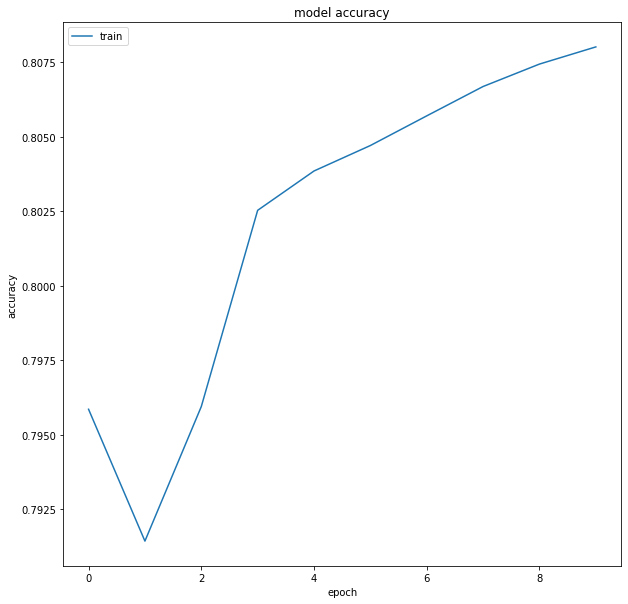

In [23]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

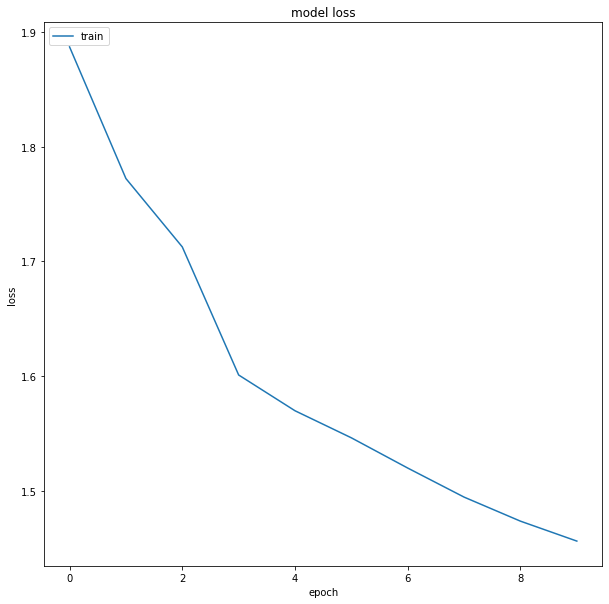

In [24]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [25]:
# dot_img_file = "d_mod-"+str(d_model)+"-d_k-"+str(d_k)+"-d_v-"+str(d_v)+"-n_heads-"+str(n_heads)+"-enc_lays-"+str(n_encoder_layers)+"-dec_lays-"+str(n_decoder_layers)+'-transformer.png'
# tf.keras.utils.plot_model(transformer, to_file=dot_img_file, show_shapes=True)

In [26]:
#transformer = keras.models.load_model('./Models/')

## Testing

In [31]:
def greedy_translate(model, source_sentence, target_sentence_start=sp_ben_bpe.bos_id()):
  # Tokenizing and padding
  source_seq = tokenize(source_sentence, sp_en_bpe)
  source_seq = tf.keras.preprocessing.sequence.pad_sequences(source_seq, maxlen = MAX_TOKENS, padding='post', truncating='post')
  predict_seq = [[target_sentence_start]]
  
  predict_sentence = [target_sentence_start] # Deep copy here to prevent updates on target_sentence_start
  while predict_sentence[-1] != sp_ben_bpe.eos_id() and len(predict_sentence) < MAX_TOKENS:
    predict_output = model([np.array(source_seq), np.array(predict_seq)], training=None)
    predict_label = tf.argmax(predict_output, axis=-1) # Pick the label with highest softmax score
    predict_seq = tf.concat([predict_seq, predict_label], axis=-1) # Updating the prediction sequence
    predict_sentence.append(predict_label[0][0].numpy())
  
  if len(predict_sentence) == MAX_TOKENS:
      return detokenize(predict_sentence, sp_ben_bpe, True, False)
  return detokenize(predict_sentence, sp_ben_bpe)

In [32]:
import tensorflow_probability as tfp

In [33]:
sentence = "I love you."
print("English Sentence: ", sentence)
print("Bengali Sentence: ", greedy_translate(transformer, sentence))

English Sentence:  I love you.
Bengali Sentence:  কিন্তু, আমি,, আমি, আমি, আমি, আমি, আমি, আমি, আমি, আমি, আমি, আমি, আমি, আমি, আমি, আমি, আমি, আমি, আমি, আমি, আমি, আমি, আমি, আমি, আমি, আমি, আমি, আমি, আমি,


In [34]:
sentences = list(test_val_data['src'][:250])
refs = [list(test_val_data['tgt'][:250])]
sys = [greedy_translate(transformer, sentence) for sentence in sentences]

In [35]:
bleu = BLEU()
bleu.corpus_score(sys, refs)

BLEU = 0.01 1.0/0.0/0.0/0.0 (BP = 1.000 ratio = 4.117 hyp_len = 14750 ref_len = 3583)

In [36]:
chrf = CHRF()
chrf.corpus_score(sys, refs)

chrF2 = 2.85

In [37]:
ter = TER()
ter.corpus_score(sys, refs)

TER = 211.89

In [38]:
def sampling_translate(model, source_sentence, temperature=0.6, target_sentence_start=sp_ben_bpe.bos_id()):
  # Tokenizing and padding
  source_seq = tokenize(source_sentence, sp_en_bpe)
  source_seq = tf.keras.preprocessing.sequence.pad_sequences(source_seq, maxlen = MAX_TOKENS, padding='post', truncating='post')
  predict_seq = [[target_sentence_start]]
  logprob = 0
  
  predict_sentence = [target_sentence_start] # Deep copy here to prevent updates on target_sentence_start
  while predict_sentence[-1] != sp_ben_bpe.eos_id() and len(predict_sentence) < MAX_TOKENS:
    predict_output = model([np.array(source_seq), np.array(predict_seq)], training=None)
    probs = predict_output[-1].numpy()[0]
    log_probs = np.log(probs)
    u = np.random.uniform(low=1e-6, high=1.0 - 1e-6, size=log_probs.shape)
    g = -np.log(-np.log(u))
    sample_idx = np.argmax(log_probs + g * temperature, axis=-1)
    sample_prob = predict_output[-1].numpy()[0][sample_idx]
    logprob += np.log(sample_prob)
    predict_label = np.arange(predict_output.shape[-1])[sample_idx] # Sample the label softmax score
    predict_seq = tf.concat([predict_seq, tf.cast([[predict_label]], dtype=tf.int32)], axis=-1) # Updating the prediction sequence
    predict_sentence.append(predict_label)
  
  if len(predict_sentence) == MAX_TOKENS:
      return detokenize(predict_sentence, sp_ben_bpe, True, False), logprob
  return detokenize(predict_sentence, sp_ben_bpe), logprob

In [39]:
sentence = "I love you."
print("English Sentence: ", sentence)
print("Bengali Sentence: ", sampling_translate(transformer, sentence))

English Sentence:  I love you.
Bengali Sentence:  ('তবে তারা, তাদের মধ্যে তার সঙ্গে আবেদন করে।', -35.21933458652347)


In [40]:
def generate_samples(sentence, n_samples, model=None, temperature=0.6):
    samples, log_probs = [], []
    for _ in range(n_samples):
        sample, logp = sampling_translate(model, sentence, temperature)
        samples.append(sample)
        log_probs.append(logp)
    return samples, log_probs

In [41]:
def rouge1_similarity(system, reference):
    sys_counter = Counter(system)
    ref_counter = Counter(reference)
    overlap = 0
    for token in sys_counter:
        token_count_sys = sys_counter[token]
        token_count_ref = ref_counter[token]
        overlap += min(token_count_ref, token_count_sys)
    precision = overlap / sum(sys_counter.values())
    recall = overlap / sum(ref_counter.values())
    if precision + recall != 0:
        rouge1_score = 2 * ((precision * recall)/(precision + recall))
    else:
        rouge1_score = 0     
    return rouge1_score

In [42]:
def weighted_avg_overlap(samples, log_probs):
    scores = {}
    for index_candidate, candidate in enumerate(samples):    
        overlap, weight_sum = 0.0, 0.0
        for index_sample, (sample, logp) in enumerate(zip(samples, log_probs)):           
            if index_candidate == index_sample:
                continue
            sample_p = float(np.exp(logp))
            weight_sum += sample_p
            sample_overlap = rouge1_similarity(candidate, sample)
            overlap += sample_p * sample_overlap
        score = overlap / weight_sum
        scores[index_candidate] = score
    return scores

In [43]:
def mbr_decode(sentence, n_samples, model=None, temperature=0.6):
    samples, log_probs = generate_samples(sentence, n_samples, model, temperature)
    scores = weighted_avg_overlap(samples, log_probs)
    max_score_key = max(scores, key=scores.get)
    return {sample:score for sample, score in zip(samples, scores.values())}

In [44]:
sentence = "I love you."
translated_sentence = mbr_decode(sentence, 2, transformer, 1)
print("English: ", sentence)
print("Bengali: ", translated_sentence)

English:  I love you.
Bengali:  {'কলকাতা, নোয়াখালী মতো-এর নিচে পূর্ণ করে তাদের কম কাছে খুশি করা এবং অন্যটি যা বিভিন্ন পরিশ্রম হয়।': 0.3739837398373983, 'তারা গোকীতে আমি এই ভূমিকা।': 0.37398373983739835}
